In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import gpytorch
import matplotlib
import matplotlib.pyplot as plt
import tqdm
import utils as utils
import scienceplots
plt.style.use('science')

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import fit_FaIRGP as fairgp
from src.structures import Scenario, ScenarioDataset

<IPython.core.display.Javascript object>

In [3]:
train_cfg = {'dataset' : {'dirpath': '../data/', 
                          'keys': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']}
            }
train_data = fairgp.make_data(train_cfg)

# test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp126', 'ssp245', 'ssp370', 'ssp585']}}
# test_data = plaingp.make_data(test_cfg)

fairgpmodel = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/all-ssps/FaIRGP/state_dict.pt')
fairgpmodel.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']}}
test_data = fairgp.make_data(test_cfg)
test_scenarios = test_data.scenarios
for s in test_scenarios.scenarios.values():
    s.name = s.name + '-test'

In [7]:
with torch.no_grad():
#     posterior_F = fairgpmodel.forcing_posterior(test_scenarios)
    posterior_mean = posterior_F.mean
    posterior_lb, posterior_ub = posterior_F.confidence_region()
    posterior_stddev = posterior_F.stddev
    posterior_lb = posterior_mean - 3 * posterior_stddev
    posterior_ub = posterior_mean + 3 * posterior_stddev

In [8]:
mT = fairgpmodel._compute_mean(test_scenarios)
mF = fairgpmodel._compute_forcing_mean(test_scenarios)

In [9]:
foo = [slice(165, 165 + 86),
       slice(165 + 86, 165 + 2 * 86),
       slice(165 + 2* 86, 165 + 3 * 86),
       slice(165 + 3*86, 165 + 4 * 86)]

In [10]:
choice = 'viridis'
cmap = matplotlib.cm.get_cmap(choice)
tas_colors = [cmap(0.), cmap(0.4), cmap(0.6), cmap(0.8), cmap(0.95)]

cmap = matplotlib.cm.get_cmap(choice)
forcing_colors = [cmap(0.), cmap(0.4), cmap(0.6), cmap(0.8), cmap(0.95)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


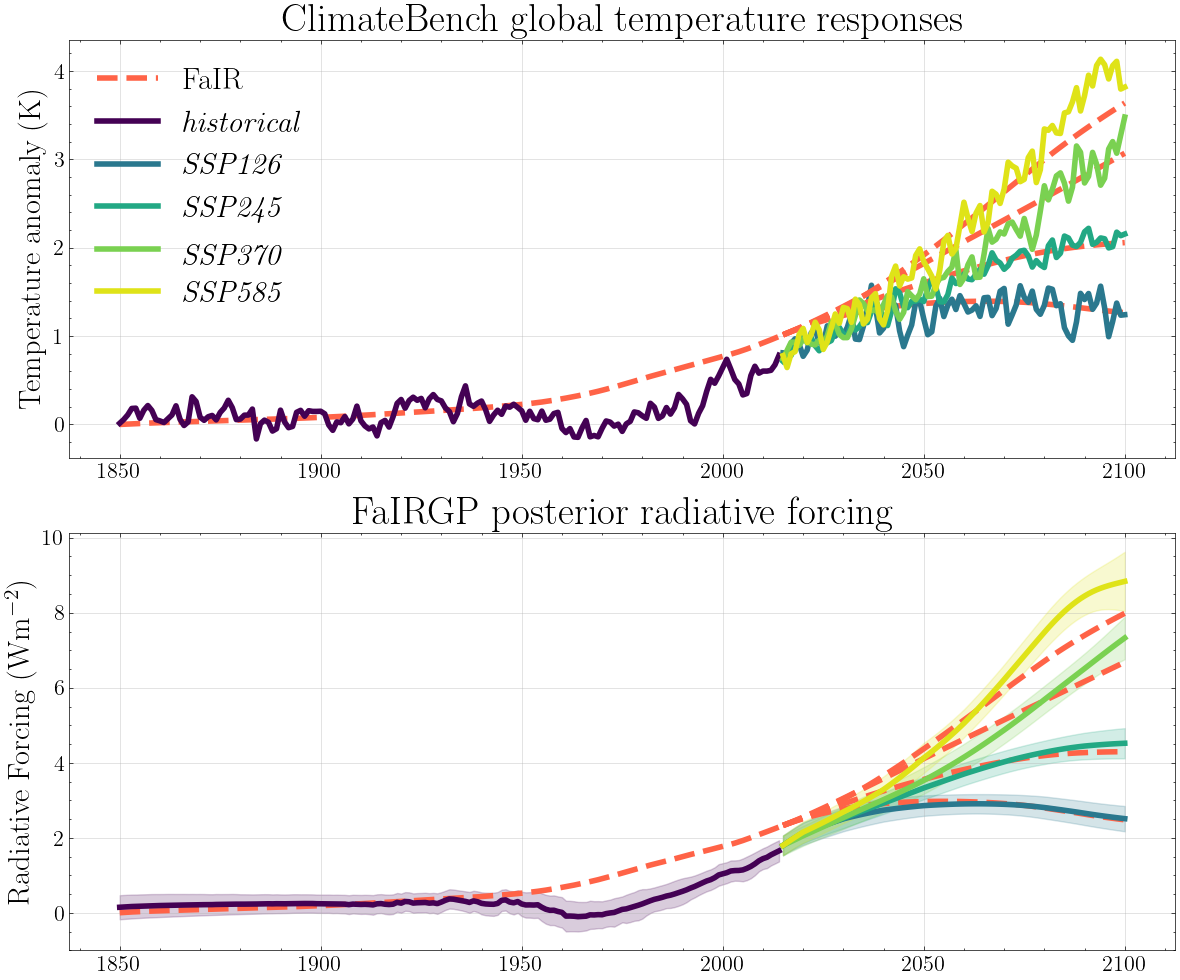

In [90]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

ax[0].plot(test_scenarios.hist_scenario.timesteps,
           mT[test_scenarios.full_slices['historical']], color='tomato', ls='--', lw=4, label='FaIR')
ax[0].plot(test_scenarios.hist_scenario.timesteps,
           test_scenarios.hist_scenario.tas, lw=4, color=tas_colors[0], label=r'$\it historical$')
ax[0].tick_params(labelsize=16)
ax[0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[0].grid(alpha=0.5)
ax[0].set_title(r'ClimateBench global temperature responses', fontsize=28)



ax[1].plot(test_scenarios.hist_scenario.timesteps,
           mF[test_scenarios.full_slices['historical']], color='tomato', ls='--', lw=4)
ax[1].plot(test_scenarios.hist_scenario.timesteps,
           posterior_mean[test_scenarios.full_slices['historical']], color=forcing_colors[0], lw=4)
ax[1].fill_between(test_scenarios.hist_scenario.timesteps,
                   posterior_lb[test_scenarios.full_slices['historical']], 
                   posterior_ub[test_scenarios.full_slices['historical']], alpha=0.2, color=forcing_colors[0])


for i, key in enumerate(['ssp126', 'ssp245', 'ssp370', 'ssp585']):
    ax[0].plot(test_scenarios[key].timesteps,
               mT[foo[i]], color='tomato', ls='--', lw=4)
    ax[0].plot(test_scenarios[key].timesteps, 
               test_scenarios[key].tas, lw=4, color=tas_colors[i + 1], label=f'$\it {key.upper()}$')
    
    ax[1].plot(test_scenarios[key].timesteps,
               mF[foo[i]], color='tomato', ls='--', lw=4)
    ax[1].plot(test_scenarios[key].timesteps,
               posterior_mean[foo[i]], color=forcing_colors[i + 1], lw=4)
    ax[1].fill_between(test_scenarios[key].timesteps,
                       posterior_lb[foo[i]], 
                       posterior_ub[foo[i]], alpha=0.2, color=forcing_colors[i + 1])


ax[1].tick_params(labelsize=16)
ax[1].set_ylabel(r'Radiative Forcing (Wm$^{-2}$)', fontsize=22)
ax[1].grid(alpha=0.5)
ax[1].set_title(r'FaIRGP posterior radiative forcing', fontsize=28)


    
legend = ax[0].legend(loc='upper left', fontsize=22)
# legend.legendHandles[4].set_alpha(0.4)

ax[1].legend(loc='upper left', fontsize=22)

plt.tight_layout()
plt.savefig('./figures/forcing-posterior-paper-figure.png', dpi=200)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


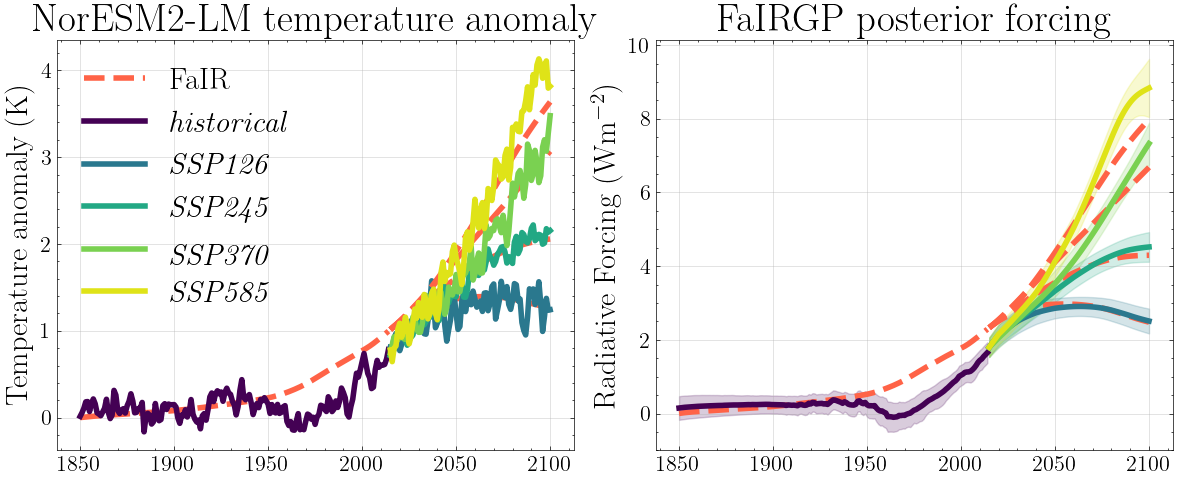

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(test_scenarios.hist_scenario.timesteps,
           mT[test_scenarios.full_slices['historical']], color='tomato', ls='--', lw=4, label='FaIR')
ax[0].plot(test_scenarios.hist_scenario.timesteps,
           test_scenarios.hist_scenario.tas, lw=4, color=tas_colors[0], label=r'$\it historical$')
ax[0].tick_params(labelsize=16)
ax[0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[0].grid(alpha=0.5)
ax[0].set_title(r'NorESM2-LM temperature anomaly', fontsize=28)



ax[1].plot(test_scenarios.hist_scenario.timesteps,
           mF[test_scenarios.full_slices['historical']], color='tomato', ls='--', lw=4)
ax[1].plot(test_scenarios.hist_scenario.timesteps,
           posterior_mean[test_scenarios.full_slices['historical']], color=forcing_colors[0], lw=4)
ax[1].fill_between(test_scenarios.hist_scenario.timesteps,
                   posterior_lb[test_scenarios.full_slices['historical']], 
                   posterior_ub[test_scenarios.full_slices['historical']], alpha=0.2, color=forcing_colors[0])


for i, key in enumerate(['ssp126', 'ssp245', 'ssp370', 'ssp585']):
    ax[0].plot(test_scenarios[key].timesteps,
               mT[foo[i]], color='tomato', ls='--', lw=4)
    ax[0].plot(test_scenarios[key].timesteps, 
               test_scenarios[key].tas, lw=4, color=tas_colors[i + 1], label=f'$\it {key.upper()}$')
    
    ax[1].plot(test_scenarios[key].timesteps,
               mF[foo[i]], color='tomato', ls='--', lw=4)
    ax[1].plot(test_scenarios[key].timesteps,
               posterior_mean[foo[i]], color=forcing_colors[i + 1], lw=4)
    ax[1].fill_between(test_scenarios[key].timesteps,
                       posterior_lb[foo[i]], 
                       posterior_ub[foo[i]], alpha=0.2, color=forcing_colors[i + 1])


ax[1].tick_params(labelsize=16)
ax[1].set_ylabel(r'Radiative Forcing (Wm$^{-2}$)', fontsize=22)
ax[1].grid(alpha=0.5)
ax[1].set_title(r'FaIRGP posterior forcing', fontsize=28)


    
legend = ax[0].legend(loc='upper left', fontsize=22)
# legend.legendHandles[4].set_alpha(0.4)

ax[1].legend(loc='upper left', fontsize=22)

plt.tight_layout()
plt.savefig('../sandbox/figures/forcing-posterior.png', dpi=200)
plt.show()

In [46]:
cmap = matplotlib.cm.get_cmap('viridis')
tas_colors = [cmap(0.), cmap(0.2), cmap(0.4), cmap(0.6), cmap(0.8)]

cmap = matplotlib.cm.get_cmap('viridis')
forcing_colors = [cmap(0.), cmap(0.2), cmap(0.4), cmap(0.6), cmap(0.8)]

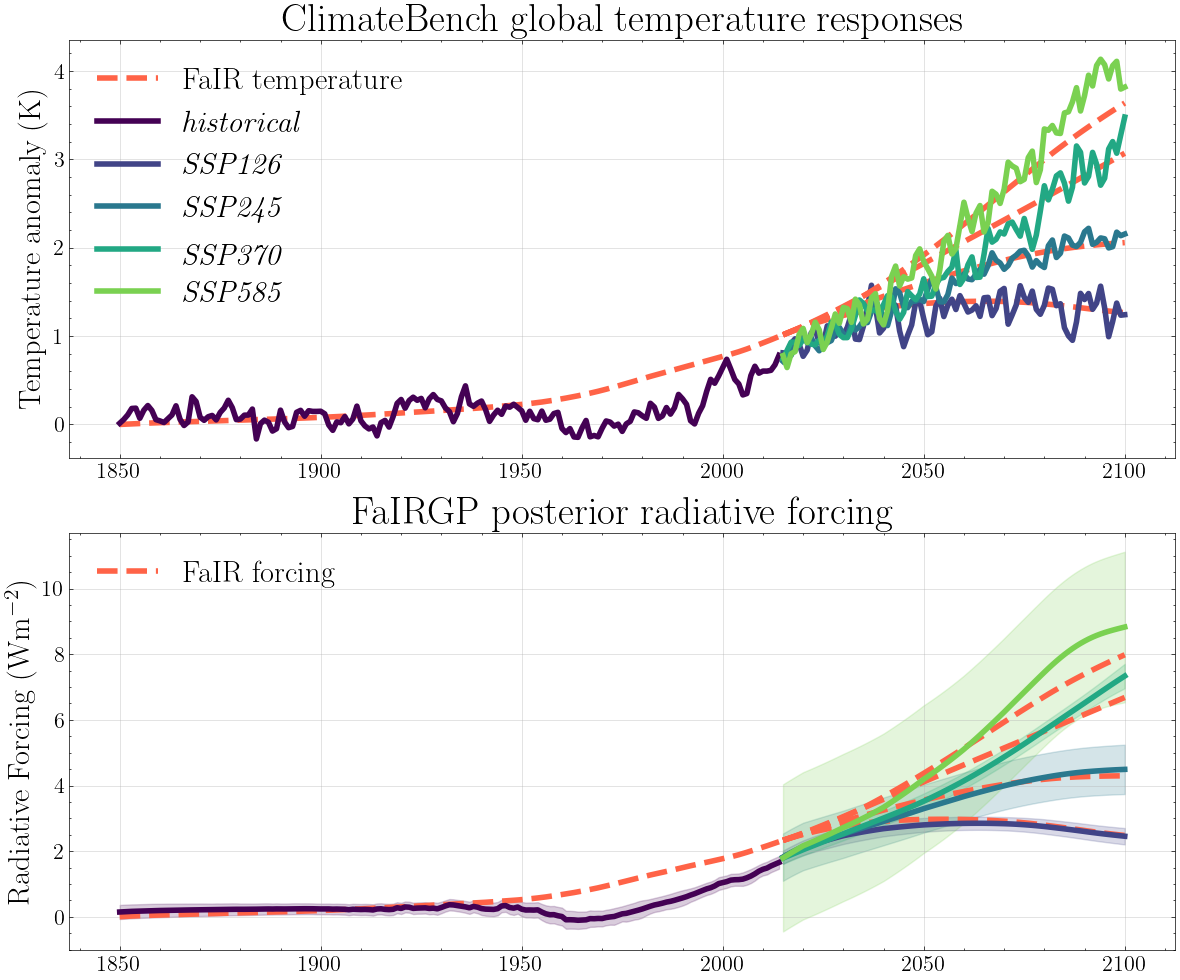

In [52]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

ax[0].plot(posteriors['historical']['time'],
           posteriors['historical']['test_tas_fair'], color='tomato', ls='--', lw=4, label='FaIR temperature')
ax[0].plot(posteriors['historical']['time'], 
           posteriors['historical']['test_tas'], lw=4, color=tas_colors[0], label=r'$\it historical$')
ax[0].tick_params(labelsize=16)
ax[0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[0].grid(alpha=0.5)
ax[0].set_title(r'ClimateBench global temperature responses', fontsize=28)



ax[1].plot(posteriors['historical']['time'],
           posteriors['historical']['FaIR'], color='tomato', ls='--', lw=4, label='FaIR forcing')
ax[1].plot(posteriors['historical']['time'],
           posteriors['historical']['mean'], color=forcing_colors[0], lw=4)
ax[1].fill_between(posteriors['historical']['time'],
                   posteriors['historical']['lb'], 
                   posteriors['historical']['ub'], alpha=0.2, color=forcing_colors[0])


for i, key in enumerate(['ssp126', 'ssp245', 'ssp370', 'ssp585']):
    ax[0].plot(posteriors[key]['time'],
               posteriors[key]['test_tas_fair'], color='tomato', ls='--', lw=4)
    ax[0].plot(posteriors[key]['time'], 
               posteriors[key]['test_tas'], lw=4, color=tas_colors[i + 1], label=f'$\it {key.upper()}$')
    
    ax[1].plot(posteriors[key]['time'],
               posteriors[key]['FaIR'], color='tomato', ls='--', lw=4)
    ax[1].plot(posteriors[key]['time'],
               posteriors[key]['mean'], color=forcing_colors[i + 1], lw=4)
    ax[1].fill_between(posteriors[key]['time'],
                       posteriors[key]['lb'], 
                       posteriors[key]['ub'], alpha=0.2, color=forcing_colors[i + 1])


    
ax[1].tick_params(labelsize=16)
ax[1].set_ylabel(r'Radiative Forcing (Wm$^{-2}$)', fontsize=22)
ax[1].grid(alpha=0.5)
ax[1].set_title(r'FaIRGP posterior radiative forcing', fontsize=28)


    
legend = ax[0].legend(loc='upper left', fontsize=22)
# legend.legendHandles[4].set_alpha(0.4)

ax[1].legend(loc='upper left', fontsize=22)


plt.tight_layout()
plt.savefig('./figures/forcing-posterior-paper-figure.png', dpi=200)
plt.show()

In [12]:
scenario_keys = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
posteriors = {key: get_forcing_posterior(key) for key in scenario_keys}

In [11]:
foo

{'time': tensor([1850., 1851., 1852., 1853., 1854., 1855., 1856., 1857., 1858., 1859.,
         1860., 1861., 1862., 1863., 1864., 1865., 1866., 1867., 1868., 1869.,
         1870., 1871., 1872., 1873., 1874., 1875., 1876., 1877., 1878., 1879.,
         1880., 1881., 1882., 1883., 1884., 1885., 1886., 1887., 1888., 1889.,
         1890., 1891., 1892., 1893., 1894., 1895., 1896., 1897., 1898., 1899.,
         1900., 1901., 1902., 1903., 1904., 1905., 1906., 1907., 1908., 1909.,
         1910., 1911., 1912., 1913., 1914., 1915., 1916., 1917., 1918., 1919.,
         1920., 1921., 1922., 1923., 1924., 1925., 1926., 1927., 1928., 1929.,
         1930., 1931., 1932., 1933., 1934., 1935., 1936., 1937., 1938., 1939.,
         1940., 1941., 1942., 1943., 1944., 1945., 1946., 1947., 1948., 1949.,
         1950., 1951., 1952., 1953., 1954., 1955., 1956., 1957., 1958., 1959.,
         1960., 1961., 1962., 1963., 1964., 1965., 1966., 1967., 1968., 1969.,
         1970., 1971., 1972., 1973., 1974., 

In [ ]:
def get_forcing_posterior(scenario_key):
    test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': [scenario_key]}}
    test_scenarios = fairgp.make_data(test_cfg).scenarios
    test_scenarios[0].name = test_scenarios[0].name + '-test'
    with torch.no_grad():
        posterior_F = fairgpmodel.forcing_posterior(test_scenarios)
    mT = fairgpmodel._compute_mean(test_scenarios)
    mF = fairgpmodel._compute_forcing_mean(test_scenarios)
    posterior_mean = posterior_F.mean
    posterior_lb, posterior_ub = posterior_F.confidence_region()
    output = {'time': test_scenarios.timesteps,
              'FaIR': mF,
              'mean': posterior_mean,
              'lb': posterior_lb,
              'ub': posterior_ub,
              'test_tas_fair': mT,
              'test_tas': test_scenarios.tas}
    return output